In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os
import seaborn as sns
%matplotlib inline

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=1, max_count=1000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [4]:
process_type='inter'

species='mouse'
SRP_name='aggregates'
resolution='1kbp_raw'

In [7]:
base_folder='/grid/gillis/data_norepl/lohia'

In [ ]:
"/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/"

In [51]:
df = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [62]:
df[df['cell_type']=='Lamp5'].drop_duplicates('gene')

group cell_type   rank      gene  recurrence     auroc  \
0      GABAergic     Lamp5      1  Cacna2d1           7  0.917386   
1      GABAergic     Lamp5      2      Nfib           7  0.912118   
2      GABAergic     Lamp5      3     Fgf13           7  0.901015   
3      GABAergic     Lamp5      4     Lamp5           7  0.888027   
4      GABAergic     Lamp5      5     Nyap2           7  0.880791   
...          ...       ...    ...       ...         ...       ...   
24102  GABAergic     Lamp5  24103       Ntm           0  0.176424   
24103  GABAergic     Lamp5  24104     Kcnc2           0  0.159623   
24104  GABAergic     Lamp5  24105      Oxr1           0  0.149610   
24105  GABAergic     Lamp5  24106  Cntnap5a           0  0.135633   
24106  GABAergic     Lamp5  24107     Fgf12           0  0.097608   

       fold_change  fold_change_detection   expression  precision    recall  \
0        10.109405               2.929707   675.305674   0.426564  0.919395   
1         5.528881               2.194696  1005.675270   0.358736  0.966526   
2         6.533759               1.556656  1381.346789   0.291647  0.920615   
3        51.467129               8.456450   521.944914   0.677288  0.800378   
4         8.377744               2.048543   698.804404   0.346876  0.887232   
...            ...                    ...          ...        ...       ...   
24102     0.240207               0.797338   315.229954   0.174935  0.759377   
24103     0.178746               0.543541   160.696567   0.128253  0.512930   
24104     0.261114               0.761870   260.800365   0.170325  0.759539   
24105     0.120037               0.346815    59.033054   0.090590  0.327352   
24106     0.226506               0.784026   249.963353   0.171849  0.797407   

       population_size  n_datasets   scSS   snSS  scCv2  snCv2  snCv3M  scCv3  \
0          2057.142857           7   True   True   True   True    True   True   
1          2057.142857           7   True   True   True   True    True   True   
2          2057.142857           7   True   True   True   True    True   True   
3          2057.142857           7   True   True   True   True    True   True   
4          2057.142857           7   True   True   True   True    True   True   
...                ...         ...    ...    ...    ...    ...     ...    ...   
24102      2057.142857           7  False  False  False  False   False  False   
24103      2057.142857           7  False  False  False  False   False  False   
24104      2057.142857           7  False  False  False  False   False  False   
24105      2057.142857           7  False  False  False  False   False  False   
24106      2057.142857           7  False  False  False  False   False  False   

       snCv3Z  
0        True  
1        True  
2        True  
3        True  
4        True  
...       ...  
24102   False  
24103   False  
24104   False  
24105   False  
24106   False  

[24107 rows x 20 columns]

In [29]:
df[(df['group']!='GABAergic') & (df['group']!='Glutamatergic')]

group       cell_type   rank           gene  recurrence     auroc  \
0        L2/3 IT       L2/3 IT_1      1  6530403H02Rik           5  0.842734   
1        L2/3 IT       L2/3 IT_1      2        Adamts2           5  0.752062   
2        L2/3 IT       L2/3 IT_1      3        Col23a1           5  0.702306   
3        L2/3 IT       L2/3 IT_1      4            Met           5  0.702247   
4        L2/3 IT       L2/3 IT_1      5            Ust           5  0.696202   
...          ...             ...    ...            ...         ...       ...   
2073197      Vip  Vip Serpinf1_3  24103          Lrfn5           0  0.116621   
2073198      Vip  Vip Serpinf1_3  24104          Synpr           0  0.112468   
2073199      Vip  Vip Serpinf1_3  24105          Csmd1           0  0.100208   
2073200      Vip  Vip Serpinf1_3  24106          Csmd3           0  0.090827   
2073201      Vip  Vip Serpinf1_3  24107            Vip           0  0.080291   

         fold_change  fold_change_detection  expression  precision    recall  \
0           5.410202               2.606655  255.840030   0.095304  0.830882   
1           7.557666               4.621909   99.357999   0.152135  0.582932   
2          12.460411               7.980352   61.676311   0.219897  0.446298   
3           9.147210               6.442665   53.928589   0.201546  0.445979   
4           6.217147               3.645296   59.489654   0.121974  0.479271   
...              ...                    ...         ...        ...       ...   
2073197     0.073556               0.183328    0.000000   0.006253  0.317111   
2073198     0.256276               0.921884  506.148744   0.014278  0.903262   
2073199     0.071547               0.134812    0.000000   0.011030  0.560873   
2073200     0.105324               0.321015    0.000000   0.013325  0.703769   
2073201     0.013518               0.173482    0.000000   0.006164  0.332670   

         population_size  n_datasets   scSS   snSS  scCv2  snCv2  snCv3M  \
0             492.833333           6    NaN  False   True   True    True   
1             492.833333           6    NaN  False   True   True    True   
2             492.833333           6    NaN  False   True   True    True   
3             492.833333           6    NaN  False   True   True    True   
4             492.833333           6    NaN  False   True   True    True   
...                  ...         ...    ...    ...    ...    ...     ...   
2073197        45.000000           7  False  False  False  False   False   
2073198        45.000000           7  False  False  False  False   False   
2073199        45.000000           7  False  False  False  False   False   
2073200        45.000000           7  False  False  False  False   False   
2073201        45.000000           7  False  False  False  False   False   

         scCv3 snCv3Z  
0         True   True  
1         True   True  
2         True   True  
3         True   True  
4         True   True  
...        ...    ...  
2073197  False  False  
2073198  False  False  
2073199  False  False  
2073200  False  False  
2073201  False  False  

[2073202 rows x 20 columns]

In [14]:
df

# Meta marker list generated on 2020-10-28. Ordered by recurrence among DE genes (FC >= 4  \
group cell_type    rank  gene   recurrence auroc              fold_change        fold_change_detection expression                                                precision                                          
all   GABAergic    1     Gad1   7          0.941159411317378  116.96047159974    9.28907818882139      820.463485580533                                  0.659089466762969                                          
                   2     Gad2   7          0.928440082860409  139.811414901866   13.9870457111271      659.151565619488                                  0.730005415287648                                          
                   3     Erbb4  7          0.921448587842508  81.7173828178188   5.73641474534021      2257.1677532732                                   0.514808664813766                                          
                   4     Kcnip1 7          0.91691910630644   32.2520375224199   10.7964197076623      588.571993361899                                  0.687830489855754                                          
...                                                                                                                                                                    ...                                          
      Non-Neuronal 24103 Nrxn3  0          0.0283987681101678 0.0617315649529713 0.28621725451708      131.248362432631                                           0.031098                                          
                   24104 Grin2b 0          0.0171528165530503 0.0655242113842264 0.281321631658064     79.8224268024663                                           0.024271                                          
                   24105 Syt1   0          0.0094801527372753 0.0500359120368872 0.371855173483894     123.927758012929                                           0.033332                                          
                   24106 Snhg11 0          0.0071061007175015 0.0618561720675537 0.642094643647591     303.542617462006                                           0.039041                                          
                   24107 Meg3   0          0.0025622369777563 0.0510559117144707 0.68680852202622      335.475400444316                                           0.040432                                          

                                                                                                                               FDR <= 0.05  \
group cell_type    rank  gene   recurrence auroc              fold_change        fold_change_detection expression                   recall   
all   GABAergic    1     Gad1   7          0.941159411317378  116.96047159974    9.28907818882139      820.463485580533  0.894509737216676   
                   2     Gad2   7          0.928440082860409  139.811414901866   13.9870457111271      659.151565619488  0.865249151192807   
                   3     Erbb4  7          0.921448587842508  81.7173828178188   5.73641474534021      2257.1677532732   0.880164419205583   
                   4     Kcnip1 7          0.91691910630644   32.2520375224199   10.7964197076623      588.571993361899  0.865456060148664   
...                                                                                                                                    ...   
      Non-Neuronal 24103 Nrxn3  0          0.0283987681101678 0.0617315649529713 0.28621725451708      131.248362432631           0.423652   
                   24104 Grin2b 0          0.0171528165530503 0.0655242113842264 0.281321631658064     79.8224268024663           0.312296   
                   24105 Syt1   0          0.0094801527372753 0.0500359120368872 0.371855173483894     123.927758012929           0.417773   
                   24106 Snhg11 0          0.0071061007175015 0.0618561720675537 0.642094643647591     303.542617462006           0.683422   
 

In [16]:
df = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')

In [18]:
df

group     cell_type  rank    gene  recurrence     auroc  fold_change  \
0      all     GABAergic     1    Gad1           7  0.941159   116.960472   
1      all     GABAergic     2    Gad2           7  0.928440   139.811415   
2      all     GABAergic     3   Erbb4           7  0.921449    81.717383   
3      all     GABAergic     4  Kcnip1           7  0.916919    32.252038   
4      all     GABAergic     5   Rbms3           7  0.902093    17.038869   
...    ...           ...   ...     ...         ...       ...          ...   
2995   all  Non-Neuronal   996     Rdx           2  0.545699     3.451569   
2996   all  Non-Neuronal   997  Cox4i2           2  0.544316    10.148337   
2997   all  Non-Neuronal   998   Ahnak           2  0.543616     9.461382   
2998   all  Non-Neuronal   999    Rcn3           2  0.543308     9.104208   
2999   all  Non-Neuronal  1000    Btg1           2  0.542415     3.853762   

      fold_change_detection   expression  precision    recall  \
0                  9.289078   820.463486   0.659089  0.894510   
1                 13.987046   659.151566   0.730005  0.865249   
2                  5.736415  2257.167753   0.514809  0.880164   
3                 10.796420   588.571993   0.687830  0.865456   
4                  3.607831   340.701798   0.442861  0.871912   
...                     ...          ...        ...       ...   
2995               0.975121   130.948069   0.065731  0.374215   
2996               6.289097     9.995411   0.212369  0.092097   
2997               2.001341    32.007215   0.108670  0.132105   
2998              14.388904     8.094364   0.456046  0.087680   
2999               0.939375    83.499889   0.064659  0.319867   

      population_size  n_datasets   scSS   snSS  scCv2  snCv2  snCv3M  scCv3  \
0        10207.000000           7   True   True   True   True    True   True   
1        10207.000000           7   True   True   True   True    True   True   
2        10207.000000           7   True   True   True   True    True   True   
3        10207.000000           7   True   True   True   True    True   True   
4        10207.000000           7   True   True   True   True    True   True   
...               ...         ...    ...    ...    ...    ...     ...    ...   
2995      8908.857143           7  False  False   True  False   False   True   
2996      8908.857143           7   True  False  False  False    True  False   
2997      8908.857143           7   True  False  False  False    True  False   
2998      8908.857143           7   True  False  False  False    True  False   
2999      8908.857143           7   True  False   True  False   False  False   

      snCv3Z  
0       True  
1       True  
2       True  
3       True  
4       True  
...      ...  
2995   False  
2996   False  
2997   False  
2998   False  
2999   False  

[3000 rows x 20 columns]

In [17]:
df[(df['group']!='GABAergic') & (df['group']!='Glutamatergic')]

group     cell_type  rank    gene  recurrence     auroc  fold_change  \
0      all     GABAergic     1    Gad1           7  0.941159   116.960472   
1      all     GABAergic     2    Gad2           7  0.928440   139.811415   
2      all     GABAergic     3   Erbb4           7  0.921449    81.717383   
3      all     GABAergic     4  Kcnip1           7  0.916919    32.252038   
4      all     GABAergic     5   Rbms3           7  0.902093    17.038869   
...    ...           ...   ...     ...         ...       ...          ...   
2995   all  Non-Neuronal   996     Rdx           2  0.545699     3.451569   
2996   all  Non-Neuronal   997  Cox4i2           2  0.544316    10.148337   
2997   all  Non-Neuronal   998   Ahnak           2  0.543616     9.461382   
2998   all  Non-Neuronal   999    Rcn3           2  0.543308     9.104208   
2999   all  Non-Neuronal  1000    Btg1           2  0.542415     3.853762   

      fold_change_detection   expression  precision    recall  \
0                  9.289078   820.463486   0.659089  0.894510   
1                 13.987046   659.151566   0.730005  0.865249   
2                  5.736415  2257.167753   0.514809  0.880164   
3                 10.796420   588.571993   0.687830  0.865456   
4                  3.607831   340.701798   0.442861  0.871912   
...                     ...          ...        ...       ...   
2995               0.975121   130.948069   0.065731  0.374215   
2996               6.289097     9.995411   0.212369  0.092097   
2997               2.001341    32.007215   0.108670  0.132105   
2998              14.388904     8.094364   0.456046  0.087680   
2999               0.939375    83.499889   0.064659  0.319867   

      population_size  n_datasets   scSS   snSS  scCv2  snCv2  snCv3M  scCv3  \
0        10207.000000           7   True   True   True   True    True   True   
1        10207.000000           7   True   True   True   True    True   True   
2        10207.000000           7   True   True   True   True    True   True   
3        10207.000000           7   True   True   True   True    True   True   
4        10207.000000           7   True   True   True   True    True   True   
...               ...         ...    ...    ...    ...    ...     ...    ...   
2995      8908.857143           7  False  False   True  False   False   True   
2996      8908.857143           7   True  False  False  False    True  False   
2997      8908.857143           7   True  False  False  False    True  False   
2998      8908.857143           7   True  False  False  False    True  False   
2999      8908.857143           7   True  False   True  False   False  False   

      snCv3Z  
0       True  
1       True  
2       True  
3       True  
4       True  
...      ...  
2995   False  
2996   False  
2997   False  
2998   False  
2999   False  

[3000 rows x 20 columns]

In [10]:
with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/1kbp_raw/max/contact_top1/hic_gene_inter_none_by_allbins_top1.h5', 'r') as hf:
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [11]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [1000]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

In [12]:
cat_list_genes = marker_table.index.tolist()

In [1027]:
len(cat_list_genes)

15753

In [13]:
    input_path=f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b {base_folder}/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  {base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    

    
    



    #if species == 'human':

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #else:

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #df_cre['start_bin'] = df_cre['start']/resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    #df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    #df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    #df_cre['cre'] = 1
    #df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    
    #cre_bins = bins_bed.merge(df_cre, left_on='pos', right_on='start_bin')['bin_id'].tolist()
    

                                                                

      
    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
    chrom_index_list = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])
        
        chrom_index_list_intra[chrom] = index_list

    exp_file = hm.hiCMatrix(f'{base_folder}/hi_c_data_processing/software/CoCoCoNet/networks/{species}_prioAggNet.h5')
    exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
    chrom_vals = [x[0] for x in exp_file.cut_intervals]
    
    with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
            tot_g = (list(hf.keys()))
    
    if resolution == '1kbp_raw':
        prec = 'float32'
    else:
        prec = 'float32'
    
    
        
    finite_list = []
    gene_list_list = []
    chrn_write_list_list = []
    my_data_thresh_list = []
    gene_depth_list = []
    
    marker_contacts_list_inter = []

    gene_list = []
        
    chrn_write_list = []
    
    for each_chrom in chr_list:
      
        
        if process_type == 'inter':


            with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                    
                                      if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)
                                            my_data[chrom_index_list[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)

        else:

            with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                        if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            my_data[chrom_index_list_intra[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)
                                        
    my_data = np.array(marker_contacts_list_inter)
                                    

In [14]:
my_data_zcore = stats.zscore(my_data,axis=1, nan_policy='omit')  

In [230]:
import random
o_list = list(range(1,100))
all_marker_1 = set(random.sample(o_list, 50))

all_marker_2 = set(o_list) - set(all_marker_1)

all_marker_1 = list(all_marker_1)
all_marker_2 = list(all_marker_2)

In [16]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [100]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        #marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)
        #marker_list_temp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        #marker_list_temp['group'] = marker_list_temp['cell_type']
        #marker_list = pd.concat([marker_list, marker_list_temp])

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            m_tmp = marker_list[marker_list['cell_type']==group2]
            #df2_list.append(m_tmp[m_tmp['rank'].isin(list(all_marker_2))])
            #df2_list.append(m_tmp[m_tmp['rank'] < 100])
            df2_list.append(m_tmp)
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [18]:
    marker_list.rename(columns = {'group':'classt'}, inplace = True)
    marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['cell_type'] = marker_list['group'].tolist()

In [254]:
if marker_level == 'cluster':

    marker_list_t = pd.read_csv(f'{base_folder}//hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')

    marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

    marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
    marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


    marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']], how='left')
    
if marker_level == 'subclass':
    marker_list.rename(columns = {'group':'classt'}, inplace = True)
    marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['cell_type'] = marker_list['group'].tolist()

    
if marker_level == 'class':
    #marker_list.rename(columns = {'group':'classt'}, inplace = True)
    #marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['group'] = marker_list['cell_type'].tolist()
    marker_list['classt'] = marker_list['cell_type'].tolist()
    #marker_list['cell_type'] = marker_list['Ensembl_gene_identifier'].tolist()

In [255]:
marker_list['classt'] = [y if y=='Non-Neuronal' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
marker_list['classt'] = ['Glutamatergic' if y=='L4/5 IT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
marker_list['classt'] = ['Glutamatergic' if y=='L5 PT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
#market_list = marker_list.dropna(subset=['classt'])

In [851]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [100]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        #marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_cluster_markers.csv.gz', skiprows=1)
        marker_list_t = pd.read_csv(f'{base_folder}//hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')

        marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

        marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)
        
        
        
        marker_list = marker_list[['gene', 'group', 'cell_type', 'recurrence', 'n_datasets', 'rank', 'auroc']].merge(marker_list_t[['classt', 'group']], how='left')
        
        marker_list['classt'] = ['Glutamatergic' if y=='L4/5 IT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
        marker_list['classt'] = ['Glutamatergic' if y=='L5 PT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
        
        
        
        cluster_groups = marker_list['group'].drop_duplicates().tolist()
        
        
        marker_list_tmp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')
        
        marker_list_tmp2 = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)
        
        
        marker_list_tmp = pd.concat([marker_list_tmp2, marker_list_tmp])
        
        
        marker_list_tmp.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_tmp.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list_tmp['cell_type'] = marker_list_tmp['group'].tolist()
        
        
        marker_list = pd.concat([marker_list, marker_list_tmp[~marker_list_tmp['group'].isin(cluster_groups)]])
        #marker_list = pd.concat([marker_list, marker_list_tmp])
        
        #bakken_groups = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_final.csv')['subclass_Bakken_2022'].drop_duplicates().tolist()
        
        
        
        #marker_list = marker_list[marker_list['group'].isin(bakken_groups)]
        print (marker_list)
        
        
        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']
        
        #marker_list_temp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        #marker_list_temp['group'] = marker_list_temp['cell_type']
        #marker_list = pd.concat([marker_list, marker_list_temp])

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        
        print (all_cell_types)
        df2_list = []



        for group2 in all_cell_types:
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            m_tmp = marker_list[marker_list['cell_type']==group2]
            #df2_list.append(m_tmp[m_tmp['rank'].isin(list(all_marker_2))])
            #df2_list.append(m_tmp[m_tmp['rank'] < 100])
            df2_list.append(m_tmp[m_tmp['recurrence'] >=1])
            
            #df2_list.append(m_tmp[m_tmp['%recurrence'] >0.80])
            #df2_list.append(m_tmp)
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


                gene       group   cell_type  recurrence  n_datasets  rank  \
0      6530403H02Rik     L2/3 IT   L2/3 IT_1           5           6     1   
1            Adamts2     L2/3 IT   L2/3 IT_1           5           6     2   
2            Col23a1     L2/3 IT   L2/3 IT_1           5           6     3   
3                Met     L2/3 IT   L2/3 IT_1           5           6     4   
4                Ust     L2/3 IT   L2/3 IT_1           5           6     5   
...              ...         ...         ...         ...         ...   ...   
11995         Gpcpd1  L6 IT Car3  L6 IT Car3           0           4   996   
11996          Nfat5  L6 IT Car3  L6 IT Car3           0           4   997   
11997          Lamp2  L6 IT Car3  L6 IT Car3           0           4   998   
11998         Cacnb1  L6 IT Car3  L6 IT Car3           0           4   999   
11999        Pitpnm2  L6 IT Car3  L6 IT Car3           0           4  1000   

          auroc         classt  fold_change  fold_change_detect

In [852]:
marker_list = marker_list.sample(frac=1)

marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

In [853]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]


#df_gene_tp = df_gene_tp.fillna(0)

In [854]:
df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

In [855]:
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()

In [764]:
#df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [61]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



In [856]:
blacklist_bins = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_bin_blacklist_1kb.bed', sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'c1', 'c2', 'c3', 'c4'])


In [857]:
pure_bins = list(set(df_gene_tp_all_info_mean.columns.tolist()) - set(blacklist_bins['bin_id'].tolist()))

In [229]:
features_sc_df = pd.DataFrame(features_sc.T,  index=features.T.index, columns = features.T.columns)



<ipython-input-805-cc86629d077a>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


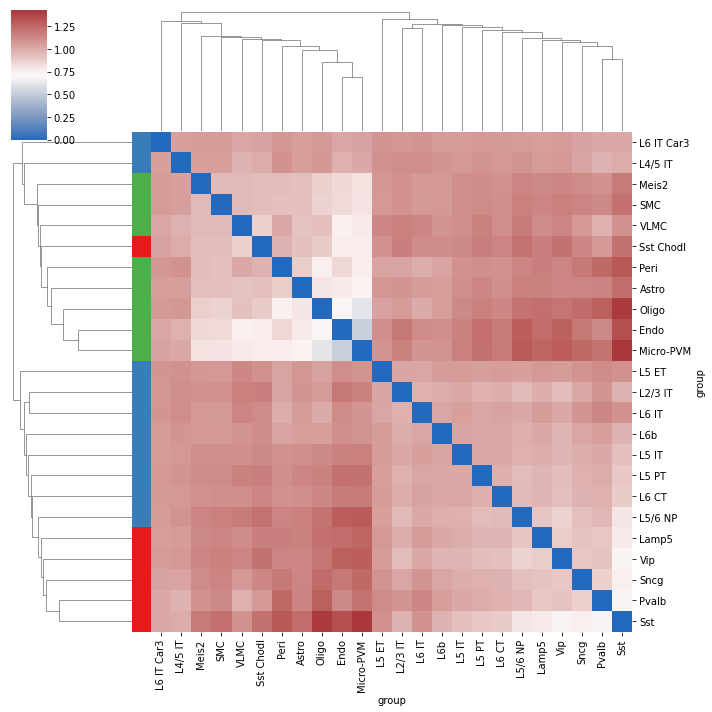

In [805]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, :]
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



<ipython-input-858-c7b68ddb351f>:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


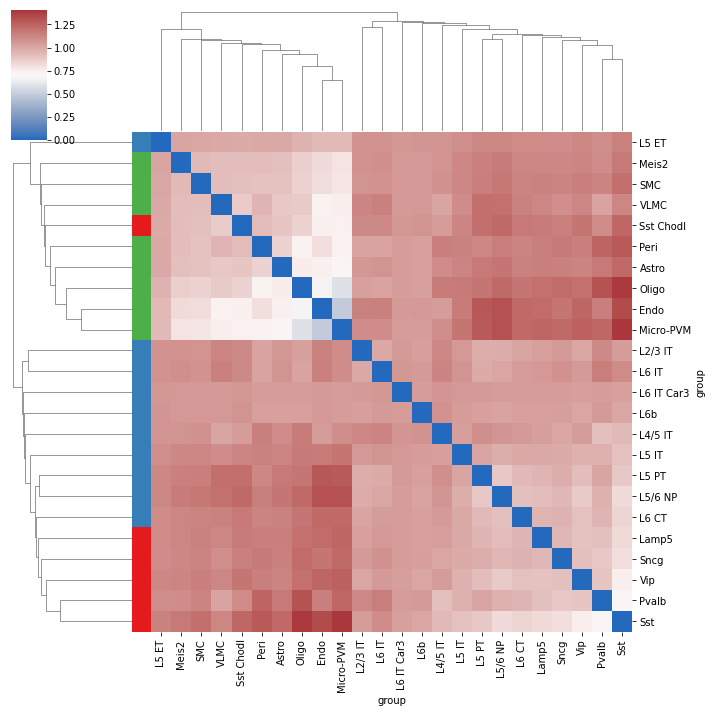

In [858]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]

#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [1022]:
dl = df_gene_tp_all_info_mean
dl = dl.reset_index()
dj = dl[dl['classt']!='Otheer']
dk = dj.groupby(['group']).mean()
features = dk.loc[:, pure_bins]
#features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)

In [1023]:
df_all_peak = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_atac_peak_1kb.bed', sep='\t', names=['chrd', 'bin_st', 'bin_end', 'bin_id', 'chr', 'start', 'end', 'peak', 'overlap'])


df_all_peak = df_all_peak[df_all_peak['overlap'] >= 250]
#df_peak_max = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/peak_mean.csv')
#df_all_peak = df_all_peak.merge(df_peak_max)


features_sc_df = pd.DataFrame(features_sc.T,  index=features.T.index, columns = features.T.columns)



In [998]:
given_group='L5 ET'

In [1009]:
dj = features.T[given_group].reset_index()

dj['spec'] = features_sc_df[given_group].tolist()

#dj = dj[dj[given_group] > 0.35]

#dj['max_bin'] = dk_per_bin_mean.tolist()

dj = dj[dj[given_group] > dj[given_group].quantile([0.75]).tolist()[0]]


#print (dj[given_group].quantile([0, 0.25,0.5,0.75]))
#print (dj[given_group].median())

dj = dj.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=[ 'spec', given_group, 'overlap'], ascending=False).drop_duplicates('peak')


#dj = dj.sort_values(by=['spec', given_group], ascending=False)
#dj = dj[dj['mean'] >.01]

dj['rank'] = list(range(1,dj.shape[0]+1))


In [1008]:
dj[given_group].quantile([0.75]).tolist()[0]

0.24166888743638992

In [1010]:
dj[dj['peak'].isin(['chr1:38828697-38829197'])]

index     L5 ET      spec  chrd    bin_st   bin_end  bin_id   chr  \
1382  38828  0.379207  1.962152  chr1  38828000  38829000   38828  chr1   

         start       end                    peak  overlap   rank  
1382  38828697  38829197  chr1:38828697-38829197      303  24071

In [1011]:
dj['L5 ET']

133184    16.825708
133183    16.825708
122703    20.339344
122702    20.339344
59318      8.656367
            ...    
226193     0.331582
100734     0.308490
126604     0.317346
126605     0.317346
165027     0.292650
Name: L5 ET, Length: 228712, dtype: float32

In [942]:
dj

index     Astro      spec   chrd     bin_st    bin_end   bin_id  \
220726  1455381  9.583613  4.786478  chr10   60234000   60235000  1455381   
193037  1293008  5.141614  4.770710   chr9   22457000   22458000  1293008   
199157  1320226  3.976941  4.759979   chr9   49675000   49676000  1320226   
199156  1320226  3.976941  4.759979   chr9   49675000   49676000  1320226   
199152  1320215  2.688686  4.747832   chr9   49664000   49665000  1320215   
...         ...       ...       ...    ...        ...        ...      ...   
57362    415820  0.021378 -2.518241   chr3   38234000   38235000   415820   
153645  1060344  0.158230 -2.599392   chr7   64637000   64638000  1060344   
117078   821541  0.014864 -2.729342   chr5  127406000  127407000   821541   
15435    136682  0.087260 -2.808671   chr1  136682000  136683000   136682   
301512  1929381  0.163508 -2.967395  chr14   40904000   40905000  1929381   

          chr      start        end                      peak  overlap    rank  
220726  chr10   60233959   60234459   chr10:60233959-60234459      459       1  
193037   chr9   22457380   22457880    chr9:22457380-22457880      500       2  
199157   chr9   49675464   49675964    chr9:49675464-49675964      500       3  
199156   chr9   49674751   49675251    chr9:49674751-49675251      251       4  
199152   chr9   49663881   49664381    chr9:49663881-49664381      381       5  
...       ...        ...        ...                       ...      ...     ...  
57362    chr3   38234296   38234796    chr3:38234296-38234796      500  383522  
153645   chr7   64637139   64637639    chr7:64637139-64637639      500  383523  
117078   chr5  127406231  127406731  chr5:127406231-127406731      500  383524  
15435    chr1  136682537  136683037  chr1:136682537-136683037      463  383525  
301512  chr14   40904554   40905054   chr14:40904554-40905054      446  383526  

[383526 rows x 13 columns]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='rank', ylabel='spec'>

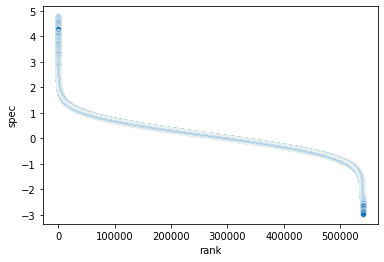

In [905]:
sns.scatterplot(dj['rank'], dj['spec'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='rank', ylabel='spec'>

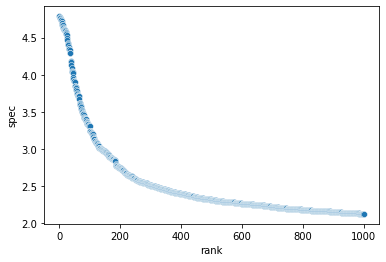

In [933]:
sns.scatterplot(dj['rank'].head(1000), dj['spec'].head(1000))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='rank', ylabel='Astro'>

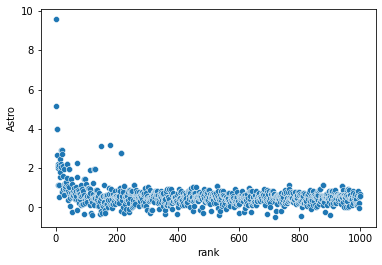

In [934]:
sns.scatterplot(dj['rank'].head(1000), dj['Astro'].head(1000))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='rank', ylabel='Astro'>

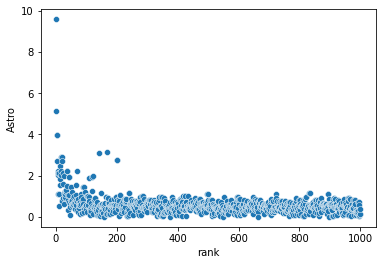

In [943]:
sns.scatterplot(dj['rank'].head(1000), dj['Astro'].head(1000))

In [1024]:
df_result_list = []
for given_group in bakken_groups:
    if given_group == 'OPC':
        given_group = 'Oligo'
    
        dt = features.T[given_group].reset_index()
        dt['spec'] = features_sc_df[given_group].tolist()
        dt = dt[dt['index'].isin(pure_bins)]
        print (dt)
        dt = dt[dt[given_group] > dt[given_group].quantile([0.75]).tolist()[0]]
        dt = dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', given_group, 'overlap'], ascending=False).drop_duplicates('peak').head(10000)
        
        dt['rank'] = list(range(1,dt.shape[0]+1))
        
        dt['subclass_Bakken_2022'] = 'OPC'
        df_result_list.append(dt[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank', 'bin_id', 'peak']])
    else:
        dt = features.T[given_group].reset_index()
        dt['spec'] = features_sc_df[given_group].tolist()
        dt = dt[dt['index'].isin(pure_bins)]
        dt = dt[dt[given_group] > dt[given_group].quantile([0.75]).tolist()[0]]
        dt = dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', given_group, 'overlap'], ascending=False).drop_duplicates('peak').head(10000)
        
        dt['rank'] = list(range(1,dt.shape[0]+1))
        dt['subclass_Bakken_2022'] = given_group
        
        df_result_list.append(dt[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank', 'bin_id', 'peak']])


           index     Oligo      spec
0              0 -0.668247  0.739968
1              1 -0.668247  0.739968
2              2 -0.668247  0.739968
3              3 -0.668247  0.739968
4              4 -0.668247  0.739968
...          ...       ...       ...
2323258  2462648  0.289218  0.135766
2323259  2462649  0.165607 -0.419868
2323260  2462650 -0.602106  0.373138
2323261  2462651  0.153443 -0.297950
2323262  2462652  0.157564 -0.632529

[2323263 rows x 3 columns]


In [1025]:
df_findal_result = pd.concat(df_result_list)

In [1026]:
df_findal_result[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank']].to_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/lohia_final_highintense75.csv', index=False)


In [877]:
df_findal_result[df_findal_result['peak'].isin(['chr1:38828697-38829197'])].sort_values('rank')

chr     start       end subclass_Bakken_2022    rank  bin_id  \
5210  chr1  38828697  38829197                Astro   24939   38828   
5210  chr1  38828697  38829197              L2/3 IT   32611   38828   
5210  chr1  38828697  38829197                L5 ET   33425   38828   
5210  chr1  38828697  38829197                 Endo   46983   38828   
5210  chr1  38828697  38829197                L5 IT   49285   38828   
5210  chr1  38828697  38829197                  Sst  103254   38828   
5210  chr1  38828697  38829197              L5/6 NP  117590   38828   
5210  chr1  38828697  38829197                Oligo  242314   38828   
5210  chr1  38828697  38829197                  OPC  242314   38828   
5210  chr1  38828697  38829197                L6 CT  242416   38828   
5210  chr1  38828697  38829197                  L6b  316258   38828   
5210  chr1  38828697  38829197                L6 IT  321618   38828   
5210  chr1  38828697  38829197                 Sncg  349047   38828   
5210  chr1  38828697  38829197            Sst Chodl  384066   38828   
5210  chr1  38828697  38829197                Pvalb  388790   38828   
5210  chr1  38828697  38829197                 VLMC  464750   38828   
5210  chr1  38828697  38829197                Lamp5  493902   38828   
5210  chr1  38828697  38829197            Micro-PVM  516414   38828   
5210  chr1  38828697  38829197                  Vip  520194   38828   

                        peak  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197  
5210  chr1:38828697-38829197

In [1021]:
df_findal_result[df_findal_result['peak'].isin(['chr1:38828697-38829197'])].sort_values('rank')

chr     start       end subclass_Bakken_2022    rank  bin_id  \
1388  chr1  38828697  38829197                Astro   18721   38828   
1426  chr1  38828697  38829197              L2/3 IT   22444   38828   
1382  chr1  38828697  38829197                L5 ET   24071   38828   
1382  chr1  38828697  38829197                 Endo   29537   38828   
1431  chr1  38828697  38829197                  Sst   29645   38828   
1371  chr1  38828697  38829197                L5 IT   31294   38828   
1375  chr1  38828697  38829197              L5/6 NP   63431   38828   
1363  chr1  38828697  38829197                Oligo  164969   38828   
1363  chr1  38828697  38829197                  OPC  164969   38828   

                        peak  
1388  chr1:38828697-38829197  
1426  chr1:38828697-38829197  
1382  chr1:38828697-38829197  
1382  chr1:38828697-38829197  
1431  chr1:38828697-38829197  
1371  chr1:38828697-38829197  
1375  chr1:38828697-38829197  
1363  chr1:38828697-38829197  
1363  chr1:38828697-38829197

In [882]:
dj[dj['peak'].isin(['chr1:38828697-38829197'])]

index     L5 ET      spec  chrd    bin_st   bin_end  bin_id   chr  \
5210  38828  0.379207  1.962152  chr1  38828000  38829000   38828  chr1   

         start       end                    peak  overlap   rank  
5210  38828697  38829197  chr1:38828697-38829197      303  33425

In [894]:
dj[dj['peak'].isin(['chr1:38828697-38829197'])]

index     Astro      spec  chrd    bin_st   bin_end  bin_id   chr  \
5210  38828  0.328059  1.225219  chr1  38828000  38829000   38828  chr1   

         start       end                    peak  overlap   rank  
5210  38828697  38829197  chr1:38828697-38829197      303  24939

In [672]:
dj[dj['index'].isin([38828,1490431, 2354500])]

index     L5 ET      spec     rank
38632      38828  0.379207  1.584213   238625
1419298  1490431 -0.229525  1.270232   355613
2222104  2354500 -0.091064 -0.907575  1797188

In [640]:
dj[dj['index'].isin([38828,1490431, 2354500])]

index     L5 ET      spec     rank
38632      38828  0.379207  1.962152   129510
1419298  1490431 -0.229525  1.262962   338793
2222104  2354500 -0.091064 -1.060508  1853952

In [652]:
dj[dj['index'].isin([38828,1490431, 2354500])]

index   L5/6 NP      spec     rank
38632      38828  0.295562  0.757012   627189
1419298  1490431 -0.320399 -0.239429  1321931
2222104  2354500 -0.087695 -0.990600  1825987

In [575]:
dj = dj.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', 'L5/6 NP', 'overlap'], ascending=False).drop_duplicates('bin_id')



In [569]:
dj[dj['peak'].isin(['chr1:38828697-38829197'])]

index   L5/6 NP      spec  chrd    bin_st   bin_end  bin_id   chr  \
7728  38829  0.454408  2.574885  chr1  38829000  38830000   38829  chr1   
7727  38828  0.295562  0.757012  chr1  38828000  38829000   38828  chr1   

         start       end                    peak  overlap    rank  
7728  38828697  38829197  chr1:38828697-38829197      197   10715  
7727  38828697  38829197  chr1:38828697-38829197      303  176327

In [577]:
dj[dj['peak'].isin(['chr1:38828697-38829197'])]

index   L5/6 NP      spec  chrd    bin_st   bin_end  bin_id   chr  \
7728  38829  0.454408  2.574885  chr1  38829000  38830000   38829  chr1   
7727  38828  0.295562  0.757012  chr1  38828000  38829000   38828  chr1   

         start       end                    peak  overlap    rank  
7728  38828697  38829197  chr1:38828697-38829197      197    8476  
7727  38828697  38829197  chr1:38828697-38829197      303  136865

In [616]:
dj[dj['peak'].isin(['chr1:38828697-38829197'])]

index   L5/6 NP      spec  chrd    bin_st   bin_end  bin_id   chr  \
7728  38829  0.454408  2.574885  chr1  38829000  38830000   38829  chr1   
7727  38828  0.295562  0.757012  chr1  38828000  38829000   38828  chr1   

         start       end                    peak  overlap    rank  
7728  38828697  38829197  chr1:38828697-38829197      197   10725  
7727  38828697  38829197  chr1:38828697-38829197      303  176474

In [564]:
dj[dj['peak'].isin(['chr1:38828697-38829197'])]

index     L5 ET      spec  chrd    bin_st   bin_end  bin_id   chr  \
7727  38828  0.379207  1.962152  chr1  38828000  38829000   38828  chr1   
7728  38829  0.089200 -0.645175  chr1  38829000  38830000   38829  chr1   

         start       end                    peak  overlap    rank  
7727  38828697  38829197  chr1:38828697-38829197      303   50015  
7728  38828697  38829197  chr1:38828697-38829197      197  574302

In [460]:
bakken_groups = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_final.csv')['subclass_Bakken_2022'].drop_duplicates().tolist()


index    L5/6 NP      spec   chrd    bin_st   bin_end   bin_id  \
639608  1935649  19.631231  4.795076  chr14  47172000  47173000  1935649   
218106   699161  18.064947  4.794350   chr5   5026000   5027000   699161   
218104   699160  11.873650  4.793152   chr5   5025000   5026000   699160   
478278  1470735  10.577387  4.792571  chr10  75588000  75589000  1470735   
65768    222375  21.612534  4.792520   chr2  26903000  26904000   222375   
...         ...        ...       ...    ...       ...       ...      ...   
140851   463621  -0.424245 -3.766772   chr3  86035000  86036000   463621   
572277  1724824   0.105004 -3.800673  chr12  76899000  76900000  1724824   
133990   433043  -0.560128 -3.820636   chr3  55457000  55458000   433043   
129767   414217  -0.327563 -3.843418   chr3  36631000  36632000   414217   
86564    280365  -0.105965 -3.853083   chr2  84893000  84894000   280365   

          chr     start       end                     peak  overlap  
639608  chr14  47172329  47172829  chr14:47172329-47172829      500  
218106   chr5   5025866   5026366     chr5:5025866-5026366      366  
218104   chr5   5024765   5025265     chr5:5024765-5025265      265  
478278  chr10  75588177  75588677  chr10:75588177-75588677      500  
65768    chr2  26903318  26903818   chr2:26903318-26903818      500  
...       ...       ...       ...                      ...      ...  
140851   chr3  86035138  86035638   chr3:86035138-86035638      500  
572277  chr12  76899235  76899735  chr12:76899235-76899735      500  
133990   chr3  55456868  55457368   chr3:55456868-55457368      368  
129767   chr3  36631341  36631841   chr3:36631341-36631841      500  
86564    chr2  84893297  84893797   chr2:84893297-84893797      500  

[600488 rows x 12 columns]

In [422]:
bakken_groups = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_final.csv')['subclass_Bakken_2022'].drop_duplicates().tolist()


In [423]:
df_result_list = []
for given_group in bakken_groups:
    if given_group == 'OPC':
        given_group = 'Oligo'
    
        dt = features.T[given_group].reset_index()
        dt['spec'] = features_sc_df[given_group].tolist()
        dt = dt[dt['index'].isin(pure_bins)]
        dt = dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', given_group, 'overlap'], ascending=False).drop_duplicates('peak')
        dt['rank'] = list(range(1,dt.shape[0]+1))
        dt['subclass_Bakken_2022'] = 'OPC'
        df_result_list.append(dt[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank', 'bin_id']].head(100000))
    else:
        dt = features.T[given_group].reset_index()
        dt['spec'] = features_sc_df[given_group].tolist()
        dt = dt[dt['index'].isin(pure_bins)]
        dt = dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', given_group, 'overlap'], ascending=False).drop_duplicates('peak')
        dt['rank'] = list(range(1,dt.shape[0]+1))
        dt['subclass_Bakken_2022'] = given_group
        df_result_list.append(dt[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank', 'bin_id']].head(10000))


In [416]:
df_result_list = []
for given_group in bakken_groups:
    if given_group == 'OPC':
        given_group = 'Oligo'
    
        dt = features.T[given_group].reset_index()
        dt['spec'] = features_sc_df[given_group]
        dt = dt[dt['index'].isin(pure_bins)]
        dt = dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', 'overlap'], ascending=False).drop_duplicates('bin_id')
        dt['rank'] = list(range(1,dt.shape[0]+1))
        dt['subclass_Bakken_2022'] = 'OPC'
        df_result_list.append(dt[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank', 'bin_id', 'spec', given_group]])
    else:
        dt = features.T[given_group].reset_index()
        dt['spec'] = features_sc_df[given_group]
        dt = dt[dt['index'].isin(pure_bins)]
        dt = dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec',  'overlap'], ascending=False).drop_duplicates('bin_id')
        dt['rank'] = list(range(1,dt.shape[0]+1))
        dt['subclass_Bakken_2022'] = given_group
        df_result_list.append(dt[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank', 'bin_id', 'spec', given_group]])


In [424]:
df_findal_result = pd.concat(df_result_list)

In [425]:
df_all_peak[df_all_peak['bin_id'].isin([38828,1490431, 2354500])]

chrd    bin_st   bin_end  bin_id   chr     start       end  \
7727  chr1  38828000  38829000   38828  chr1  38828697  38829197   

                        peak  overlap  
7727  chr1:38828697-38829197      303

In [407]:
df_f_2 = df_findal_result[df_findal_result['rank'] <=100000]

In [408]:
df_f_2[df_f_2['bin_id'].isin([38828,1490431, 2354500])]

chr     start       end subclass_Bakken_2022   rank  bin_id      spec  \
7727  chr1  38828697  38829197                Astro  26590   38828  1.225219   
7727  chr1  38828697  38829197                 Endo  47736   38828  1.234660   
7727  chr1  38828697  38829197              L2/3 IT  36848   38828  1.800968   
7727  chr1  38828697  38829197                L5 ET  37104   38828  1.962152   
7727  chr1  38828697  38829197                L5 IT  57152   38828  1.573347   

      Sst Chodl     Astro      Endo  ...  L6 IT  Lamp5  Micro-PVM  L5/6 NP  \
7727        NaN  0.328059       NaN  ...    NaN    NaN        NaN      NaN   
7727        NaN       NaN  0.328714  ...    NaN    NaN        NaN      NaN   
7727        NaN       NaN       NaN  ...    NaN    NaN        NaN      NaN   
7727        NaN       NaN       NaN  ...    NaN    NaN        NaN      NaN   
7727        NaN       NaN       NaN  ...    NaN    NaN        NaN      NaN   

      Oligo  Pvalb  Sncg  Sst  Vip  VLMC  
7727    NaN    NaN   NaN  NaN  NaN   NaN  
7727    NaN    NaN   NaN  NaN  NaN   NaN  
7727    NaN    NaN   NaN  NaN  NaN   NaN  
7727    NaN    NaN   NaN  NaN  NaN   NaN  
7727    NaN    NaN   NaN  NaN  NaN   NaN  

[5 rows x 25 columns]

In [412]:
df_f_2[df_f_2['bin_id'].isin([38828,1490431, 2354500])]['Astro', 'Endo', 'L2/3 IT']

chr     start       end subclass_Bakken_2022   rank  bin_id      spec  \
7727  chr1  38828697  38829197                Astro  26590   38828  1.225219   
7727  chr1  38828697  38829197                 Endo  47736   38828  1.234660   
7727  chr1  38828697  38829197              L2/3 IT  36848   38828  1.800968   
7727  chr1  38828697  38829197                L5 ET  37104   38828  1.962152   
7727  chr1  38828697  38829197                L5 IT  57152   38828  1.573347   

      Sst Chodl     Astro      Endo  ...  L6 IT  Lamp5  Micro-PVM  L5/6 NP  \
7727        NaN  0.328059       NaN  ...    NaN    NaN        NaN      NaN   
7727        NaN       NaN  0.328714  ...    NaN    NaN        NaN      NaN   
7727        NaN       NaN       NaN  ...    NaN    NaN        NaN      NaN   
7727        NaN       NaN       NaN  ...    NaN    NaN        NaN      NaN   
7727        NaN       NaN       NaN  ...    NaN    NaN        NaN      NaN   

      Oligo  Pvalb  Sncg  Sst  Vip  VLMC  
7727    NaN    NaN   NaN  NaN  NaN   NaN  
7727    NaN    NaN   NaN  NaN  NaN   NaN  
7727    NaN    NaN   NaN  NaN  NaN   NaN  
7727    NaN    NaN   NaN  NaN  NaN   NaN  
7727    NaN    NaN   NaN  NaN  NaN   NaN  

[5 rows x 25 columns]

In [ ]:
os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b /grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/mm10-blacklist.v2.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > /grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_bin_blacklist_10kb.bed")
          
    

In [335]:
os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wb -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed -b /grid/gillis/home/lohia/notebooks_cre_v3/notebooks/lables.bed > /grid/gillis/home/lohia/notebooks_cre_v3/notebooks/labels_bin.bed" ) 



256

In [336]:
f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed'

'/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/all_bins_true.bed'

In [338]:
pd.read_csv('/grid/gillis/home/lohia/notebooks_cre_v3/notebooks/lables.bed', sep='\t').to_csv('/grid/gillis/home/lohia/notebooks_cre_v3/notebooks/lables.bed', index=False, sep='\t')


In [344]:
pd.read_csv('/grid/gillis/home/lohia/notebooks_cre_v3/notebooks/lables.bed', sep='\t')

chr10    95284671    95284984
0  chr18    43880294    43880333
1   chr1    38828035    38828660

In [299]:
df_findal_result[['chr', 'start', 'end', 'subclass_Bakken_2022', 'rank']].to_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/lohia_final.csv', index=False)



In [284]:
df_findal_result.drop_duplicates('subclass_Bakken_2022')

chr      start        end subclass_Bakken_2022  rank   bin_id
696492  chr16    4763182    4763682            Sst Chodl     1  2122187
3326     chr1   22977850   22978350                Astro     1    22977
709888  chr16   34967415   34967915                 Endo     1  2152391
44361    chr1  164338341  164338841              L2/3 IT     1   164338
369780   chr8   11807386   11807886                L5 ET     1  1152956
794294  chr19   22941415   22941915                L5 IT     1  2424264
639608  chr14   47172329   47172829                  L6b     1  1935649
485815  chr10   89118453   89118953                L6 CT     1  1484265
425763   chr9   47471490   47471990                L6 IT     1  1318022
201336   chr4  132382223  132382723                Lamp5     1   670008
652531  chr14   79088751   79089251            Micro-PVM     1  1967565
511545  chr11   47380657   47381157              L5/6 NP     1  1573222
604658  chr13   49347435   49347935                Oligo     1  1817402
604658  chr13   49347435   49347935                  OPC     1  1817402
716208  chr16   60059887   60060387                Pvalb     1  2177484
410230   chr8  127201329  127201829                 Sncg     1  1268350
381168   chr8   53695355   53695855                  Sst     1  1194844
447228   chr9  103628599  103629099                  Vip     1  1374180
234502   chr5   64972313   64972813                 VLMC     1   759107

<ipython-input-322-ff7f5f15c38b>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


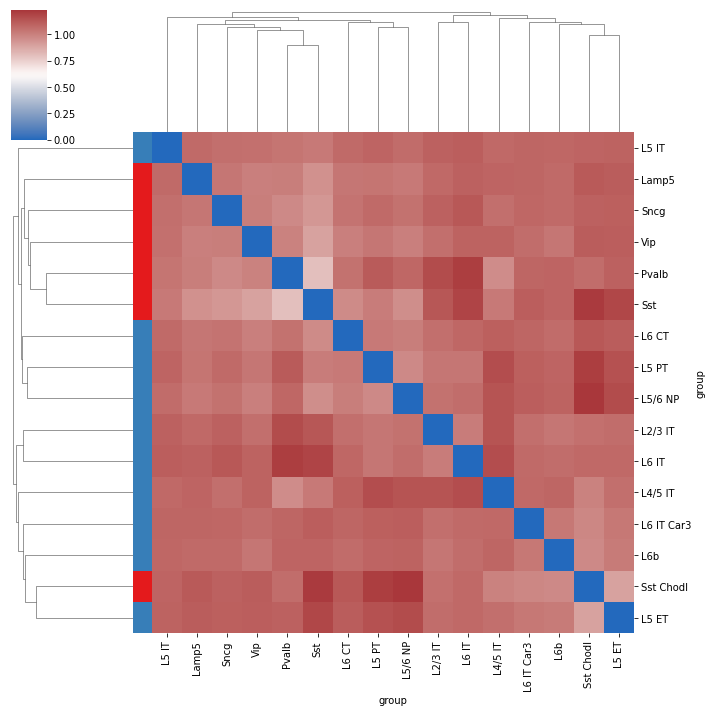

In [322]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Other']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, :]
#features = dk.loc[:, df_findal_result['bin_id'].tolist()]
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [274]:
df_findal_result.drop_duplicates('subclass_Bakken_2022')

chr      start        end subclass_Bakken_2022  rank   bin_id
696492  chr16    4763182    4763682            Sst Chodl     1  2122187
3326     chr1   22977850   22978350                Astro     1    22977
709888  chr16   34967415   34967915                 Endo     1  2152391
44361    chr1  164338341  164338841              L2/3 IT     1   164338
369780   chr8   11807386   11807886                L5 ET     1  1152956
794294  chr19   22941415   22941915                L5 IT     1  2424264
639608  chr14   47172329   47172829                  L6b     1  1935649
485815  chr10   89118453   89118953                L6 CT     1  1484265
425763   chr9   47471490   47471990                L6 IT     1  1318022
201336   chr4  132382223  132382723                Lamp5     1   670008
652531  chr14   79088751   79089251            Micro-PVM     1  1967565
511545  chr11   47380657   47381157              L5/6 NP     1  1573222
604658  chr13   49347435   49347935                Oligo     1  1817402
716208  chr16   60059887   60060387                Pvalb     1  2177484
410230   chr8  127201329  127201829                 Sncg     1  1268350
381168   chr8   53695355   53695855                  Sst     1  1194844
447228   chr9  103628599  103629099                  Vip     1  1374180
234502   chr5   64972313   64972813                 VLMC     1   759107

In [275]:
bakken_groups

['Sst Chodl',
 'Astro',
 'Endo',
 'L2/3 IT',
 'L5 ET',
 'L5 IT',
 'L6b',
 'L6 CT',
 'L6 IT',
 'Lamp5',
 'Micro-PVM',
 'L5/6 NP',
 'Oligo',
 'OPC',
 'Pvalb',
 'Sncg',
 'Sst',
 'Vip',
 'VLMC']

In [273]:
df_findal_result[df_findal_result['subclass_Bakken_2022']=='OPC']

Empty DataFrame
Columns: [chr, start, end, subclass_Bakken_2022, rank, bin_id]
Index: []

In [261]:
dt.head(10000)

index  Sst Chodl      spec   chrd     bin_st    bin_end   bin_id  \
696492  2122187   0.483616  4.783942  chr16    4763000    4764000  2122187   
279700   881428   0.346738  4.783623   chr6   35458000   35459000   881428   
167560   563239  -0.081892  4.775377   chr4   25613000   25614000   563239   
764344  2336160   0.327853  4.767207  chr18   25540000   25541000  2336160   
62721    215548  -0.203383  4.766804   chr2   20076000   20077000   215548   
...         ...        ...       ...    ...        ...        ...      ...   
488974  1491782   0.299518  2.009898  chr10   96635000   96636000  1491782   
736959  2246036   0.565072  2.009876  chr17   30404000   30405000  2246036   
539766  1627339   0.560116  2.009808  chr11  101497000  101498000  1627339   
320218  1012725  -0.213626  2.009806   chr7   17018000   17019000  1012725   
466533  1429428   0.203403  2.009803  chr10   34281000   34282000  1429428   

          chr      start        end                       peak  overlap   rank  
696492  chr16    4763182    4763682      chr16:4763182-4763682      500      1  
279700   chr6   35458277   35458777     chr6:35458277-35458777      500      2  
167560   chr4   25613361   25613861     chr4:25613361-25613861      500      3  
764344  chr18   25540434   25540934    chr18:25540434-25540934      500      4  
62721    chr2   20076383   20076883     chr2:20076383-20076883      500      5  
...       ...        ...        ...                        ...      ...    ...  
488974  chr10   96635472   96635972    chr10:96635472-96635972      500   9996  
736959  chr17   30404580   30405080    chr17:30404580-30405080      420   9997  
539766  chr11  101496981  101497481  chr11:101496981-101497481      481   9998  
320218   chr7   17018651   17019151     chr7:17018651-17019151      349   9999  
466533  chr10   34281119   34281619    chr10:34281119-34281619      500  10000  

[10000 rows x 13 columns]

In [123]:
dt = features.T['GABAergic',     'Lamp5'].reset_index()

In [124]:
dt['spec'] = features_sc[0]

In [131]:
dt.merge(df_all_peak, left_on='index', right_on='bin_id').columns

Index([         ('index', ''), ('GABAergic', 'Lamp5'),           ('spec', ''),
                       'chrd',               'bin_st',              'bin_end',
                     'bin_id',                  'chr',                'start',
                        'end',                 'peak',              'overlap'],
      dtype='object')

In [139]:
dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=[('spec', ''), ('GABAergic', 'Lamp5'), 'overlap'], ascending=False).drop_duplicates('bin_id')


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


(index, )  (GABAergic, Lamp5)  (spec, )   chrd     bin_st    bin_end  \
666405    2044772            6.936535  3.312724  chr15   31392000   31393000   
580834    1747274            3.351300  3.312043  chr12   99349000   99350000   
707772    2148423            5.400127  3.311409  chr16   30999000   31000000   
652376    1965988            4.709849  3.310905  chr14   77511000   77512000   
3326        22977            5.948706  3.310401   chr1   22977000   22978000   
...           ...                 ...       ...    ...        ...        ...   
178908     603122           -0.235218 -2.951550   chr4   65496000   65497000   
657965    2007187           -0.135670 -2.966015  chr14  118710000  118711000   
735278    2243265            0.461317 -2.986145  chr17   27633000   27634000   
184139     629042           -0.298038 -3.019186   chr4   91416000   91417000   
608635    1824320            0.165932 -3.061478  chr13   56265000   56266000   

         bin_id    chr      start        end                       peak  \
666405  2044772  chr15   31391966   31392466    chr15:31391966-31392466   
580834  1747274  chr12   99349321   99349821    chr12:99349321-99349821   
707772  2148423  chr16   30998856   30999356    chr16:30998856-30999356   
652376  1965988  chr14   77511409   77511909    chr14:77511409-77511909   
3326      22977   chr1   22977850   22978350     chr1:22977850-22978350   
...         ...    ...        ...        ...                        ...   
178908   603122   chr4   65496370   65496870     chr4:65496370-65496870   
657965  2007187  chr14  118710856  118711356  chr14:118710856-118711356   
735278  2243265  chr17   27633136   27633636    chr17:27633136-27633636   
184139   629042   chr4   91416567   91417067     chr4:91416567-91417067   
608635  1824320  chr13   56265585   56266085    chr13:56265585-56266085   

        overlap  
666405      466  
580834      500  
707772      356  
652376      500  
3326        150  
...         ...  
178908      500  
657965      144  
735278      500  
184139      433  
608635      415  

[601081 rows x 12 columns]

In [136]:
dt.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=[('GABAergic', 'Lamp5'), ('spec', ''), 'overlap'])


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


(index, )  (GABAergic, Lamp5)  (spec, )   chrd     bin_st    bin_end  \
282563     888838           -0.788880 -1.336683   chr6   42868000   42869000   
625534    1880486           -0.786126 -0.958305  chr13  112431000  112432000   
287259     904890           -0.782104 -1.191976   chr6   58920000   58921000   
593256    1780669           -0.782025 -1.120057  chr13   12614000   12615000   
598716    1803887           -0.780808 -1.229001  chr13   35832000   35833000   
...           ...                 ...       ...    ...        ...        ...   
511935    1573222            6.133825  3.166848  chr11   47380000   47381000   
688305    2101767            6.487727  3.310311  chr15   88387000   88388000   
666406    2044772            6.936535  3.312724  chr15   31392000   31393000   
666405    2044772            6.936535  3.312724  chr15   31392000   31393000   
399724    1251392            7.324749  3.168671   chr8  110243000  110244000   

         bin_id    chr      start        end                       peak  \
282563   888838   chr6   42867741   42868241     chr6:42867741-42868241   
625534  1880486  chr13  112431988  112432488  chr13:112431988-112432488   
287259   904890   chr6   58920669   58921169     chr6:58920669-58921169   
593256  1780669  chr13   12614544   12615044    chr13:12614544-12615044   
598716  1803887  chr13   35832599   35833099    chr13:35832599-35833099   
...         ...    ...        ...        ...                        ...   
511935  1573222  chr11   47380657   47381157    chr11:47380657-47381157   
688305  2101767  chr15   88386814   88387314    chr15:88386814-88387314   
666406  2044772  chr15   31392647   31393147    chr15:31392647-31393147   
666405  2044772  chr15   31391966   31392466    chr15:31391966-31392466   
399724  1251392   chr8  110242662  110243162   chr8:110242662-110243162   

        overlap  
282563      241  
625534       12  
287259      331  
593256      456  
598716      401  
...         ...  
511935      343  
688305      314  
666406      353  
666405      466  
399724      162  

[809196 rows x 12 columns]

<Axes: xlabel="('GABAergic', 'Lamp5')", ylabel='Count'>

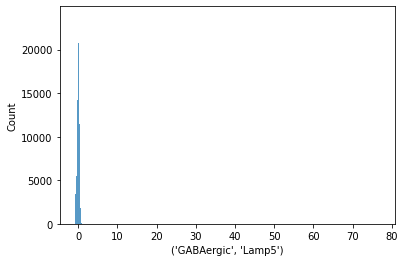

In [100]:
sns.histplot(features.iloc[0])


<Axes: ylabel='Count'>

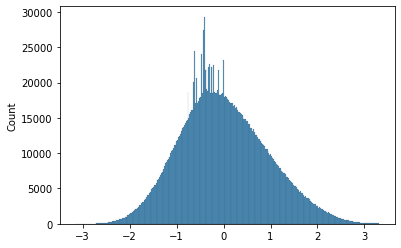

In [86]:
sns.histplot(features_sc[0])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: ylabel="('GABAergic', 'Lamp5')">

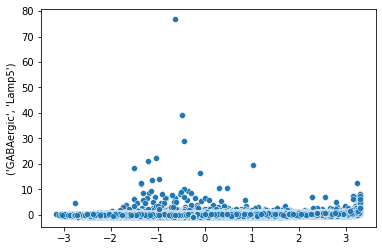

In [99]:
sns.scatterplot(features_sc[0], features.iloc[0])

In [96]:
features_sc[0].shape

(2462755,)

In [98]:
features.iloc[0]

0         -0.785142
1         -0.785142
2         -0.785142
3         -0.785142
4         -0.785142
             ...   
2462750   -0.769360
2462751   -0.769360
2462752   -0.769360
2462753   -0.769360
2462754   -0.769360
Name: (GABAergic, Lamp5), Length: 2462755, dtype: float32

In [93]:
features

0         1         2         3         4        \
classt        group                                                         
GABAergic     Lamp5     -0.785142 -0.785142 -0.785142 -0.785142 -0.785142   
              Pvalb     -0.718649 -0.718649 -0.718649 -0.718649 -0.718649   
              Sncg      -0.751139 -0.751139 -0.751139 -0.751139 -0.751139   
              Sst       -0.779665 -0.779665 -0.779665 -0.779665 -0.779665   
              Sst Chodl -0.652430 -0.652430 -0.652430 -0.652430 -0.652430   
              Vip       -0.774976 -0.774976 -0.774976 -0.774976 -0.774976   
Glutamatergic L2/3 IT   -0.807255 -0.807255 -0.807255 -0.807255 -0.807255   
              L5 IT     -0.716320 -0.716320 -0.716320 -0.716320 -0.716320   
              L5/6 NP   -0.827930 -0.827930 -0.827930 -0.827930 -0.827930   
              L6 CT     -0.786371 -0.786371 -0.786371 -0.786371 -0.786371   
              L6 IT     -0.781564 -0.781564 -0.781564 -0.781564 -0.781564   
              L6b       -0.718809 -0.718809 -0.718809 -0.718809 -0.718809   

                          5         6         7         8         9        \
classt        group                                                         
GABAergic     Lamp5     -0.785142 -0.785142 -0.785142 -0.785142 -0.785142   
              Pvalb     -0.718649 -0.718649 -0.718649 -0.718649 -0.718649   
              Sncg      -0.751139 -0.751139 -0.751139 -0.751139 -0.751139   
              Sst       -0.779665 -0.779665 -0.779665 -0.779665 -0.779665   
              Sst Chodl -0.652430 -0.652430 -0.652430 -0.652430 -0.652430   
              Vip       -0.774976 -0.774976 -0.774976 -0.774976 -0.774976   
Glutamatergic L2/3 IT   -0.807255 -0.807255 -0.807255 -0.807255 -0.807255   
              L5 IT     -0.716320 -0.716320 -0.716320 -0.716320 -0.716320   
              L5/6 NP   -0.827930 -0.827930 -0.827930 -0.827930 -0.827930   
              L6 CT     -0.786371 -0.786371 -0.786371 -0.786371 -0.786371   
              L6 IT     -0.781564 -0.781564 -0.781564 -0.781564 -0.781564   
              L6b       -0.718809 -0.718809 -0.718809 -0.718809 -0.718809   

                         ...   2462745   2462746   2462747   2462748  \
classt        group      ...                                           
GABAergic     Lamp5      ... -0.769360 -0.769360 -0.769360 -0.769360   
              Pvalb      ... -0.714963 -0.714963 -0.714963 -0.714963   
              Sncg       ... -0.746859 -0.746859 -0.746859 -0.746859   
              Sst        ... -0.784999 -0.784999 -0.784999 -0.784999   
              Sst Chodl  ... -0.663325 -0.663325 -0.663325 -0.663325   
              Vip        ... -0.768438 -0.768438 -0.768438 -0.768438   
Glutamatergic L2/3 IT    ... -0.802757 -0.802757 -0.802757 -0.802757   
              L5 IT      ... -0.724596 -0.724596 -0.724596 -0.724596   
              L5/6 NP    ... -0.825276 -0.825276 -0.825276 -0.825276   
              L6 CT      ... -0.789424 -0.789424 -0.789424 -0.789424   
              L6 IT      ... -0.793728 -0.793728 -0.793728 -0.793728   
              L6b        ... -0.716662 -0.716662 -0.716662 -0.716662   

                          2462749   2462750   2462751   2462752   2462753  \
classt        group                                                         
GABAergic     Lamp5     -0.769360 -0.769360 -0.769360 -0.769360 -0.769360   
              Pvalb     -0.714963 -0.714963 -0.714963 -0.714963 -0.714963   
              Sncg      -0.746859 -0.746859 -0.746859 -0.746859 -0.746859   
              Sst       -0.784999 -0.784999 -0.784999 -0.784999 -0.784999   
              Sst Chodl -0.663325 -0.663325 -0.663325 -0.663325 -0.663325   
              Vip       -0.768438 -0.768438 -0.768438 -0.768438 -0.768438   
Glutamatergic L2/3 IT   -0.802757 -0.802757 -0.802757 -0.802757 -0.802757   
              L5 IT     -0.724596 -0.724596 -0.724596 -0.724596 -0.724596   
              L5/6 NP   -0.825276 -0.825276 -0.825276 -0.825276 -0.825276   
            

In [95]:
features_sc.shape

(12, 2462755)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

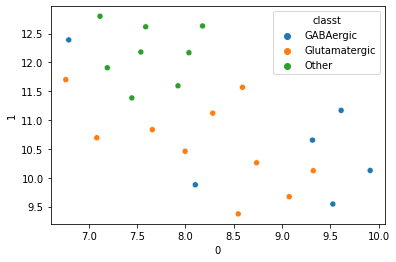

In [321]:
umap_2d = UMAP(n_components=2, init='random', random_state=1)


proj_2d = umap_2d.fit_transform(features_sc)

df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = dk.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

In [1029]:
df_atac_subclass = pd.read_csv(f'/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/subclass_mean.csv')



<ipython-input-35-595277841f4e>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


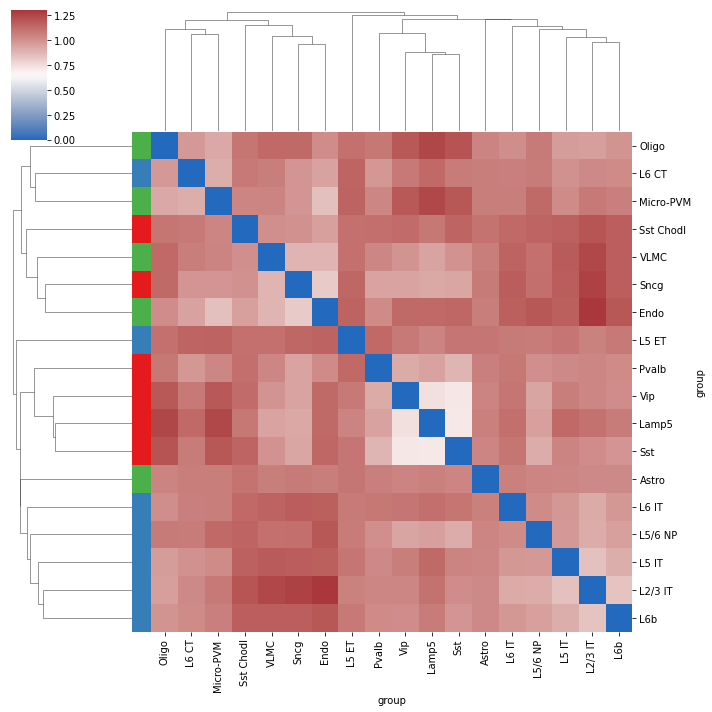

In [35]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Other']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



<ipython-input-38-6f735b5f1599>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


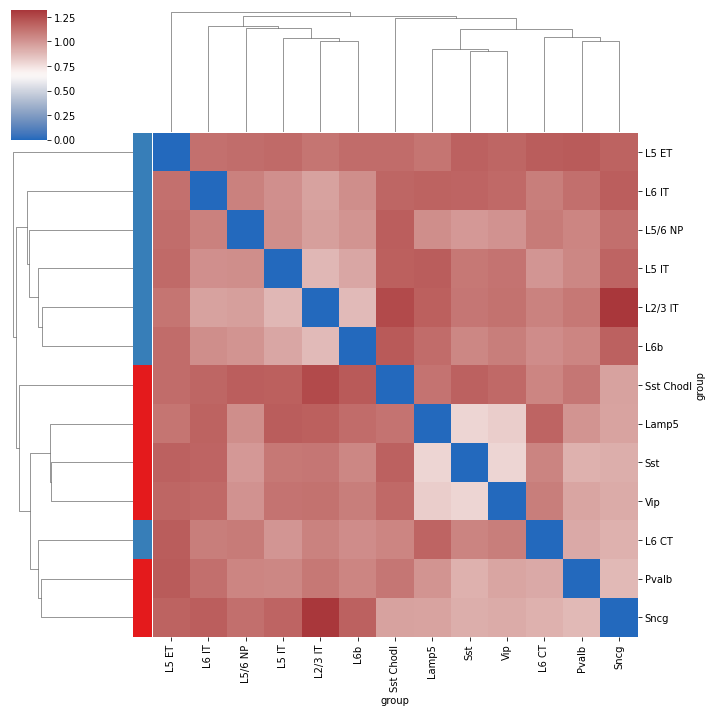

In [38]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Other']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

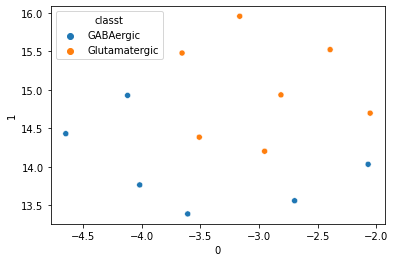

In [40]:
umap_2d = UMAP(n_components=2, init='random', random_state=10)


proj_2d = umap_2d.fit_transform(features_sc)

df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = dk.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

In [264]:
human_mouse = pd.read_csv('/grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/hglft_genome_human_mouse_10kb_0.1.bed', sep='\t', names = ['chrm', 'st', 'end', 'human_bin'])


In [265]:
human_mouse

chrm         st        end  human_bin
0        chr6  121508937  121518759          2
1        chr6  121498037  121500284          3
2        chr2  111473169  111475500          5
3        chr2  111476095  111484320          6
4        chr2  111484320  111486136          7
...       ...        ...        ...        ...
210166  chr15   89557076   89570053     287500
210167  chr15   89570053   89575122     287501
210168  chr15   89581917   89584374     287503
210169  chr15   89584374   89588548     287504
210170  chr15   89589547   89591962     287505

[210171 rows x 4 columns]

In [303]:
os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wa -wb -b /grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/hglft_genome_human_mouse_10kb_0.5.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > ./dell.bed")
          
          

0

In [295]:
df_human_mouse_com = pd.read_csv("./dell.bed", sep='\t', names = ['chrm', 'st', 'end', 'mouse_bin', 'chrme', 'ste', 'ende', 'human_bin'])



In [306]:
df_human_mouse_com['mouse_bin'].drop_duplicates().tolist()



0            320
2            321
3            322
4            323
5            324
           ...  
133180    246244
133182    246245
133183    246248
133185    246249
133187    246250
Name: mouse_bin, Length: 98690, dtype: int64

In [238]:
df_gene_tp_all_info_mean_group1 = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [246]:
df_gene_tp_all_info_mean_group2 = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [180]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [23]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
#features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]
#features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]
#features = df_gene_tp_all_info_mean.loc[:, df_human_mouse_com['mouse_bin']]
features = df_gene_tp_all_info_mean.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)




In [292]:
df_gene_tp_all_info_mean.to_csv('./mouse_10.csv')

In [24]:
umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

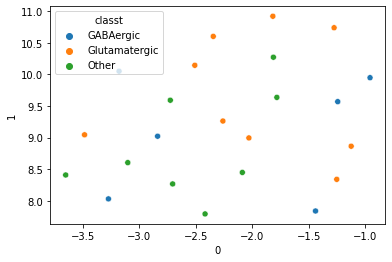

In [25]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

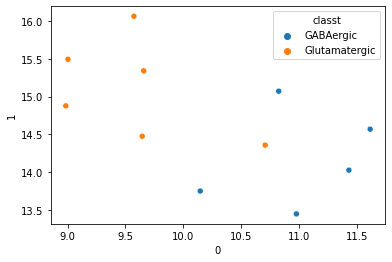

In [23]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

In [289]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

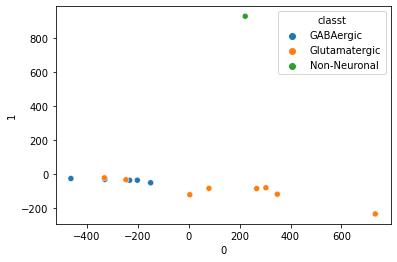

In [290]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

In [251]:
dj = pd.concat([df_gene_tp_all_info_mean_group1, df_gene_tp_all_info_mean_group2])

dj = dj.reset_index()

dj = dj[dj['classt']=='GABAergic']



from sklearn.decomposition import PCA
features = dj.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
pca = PCA(n_components=3)
proj_2da = pca.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


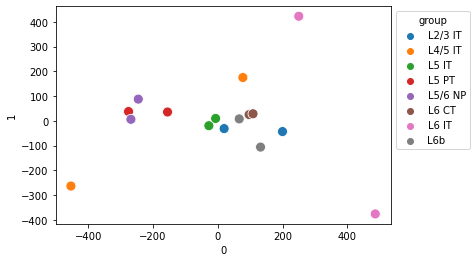

In [250]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


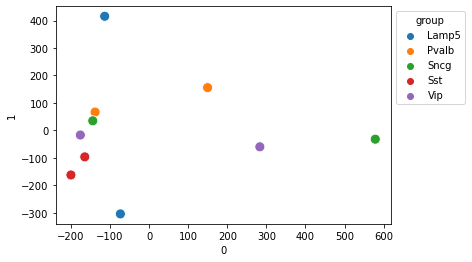

In [252]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<ipython-input-159-9c5bde4097ba>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


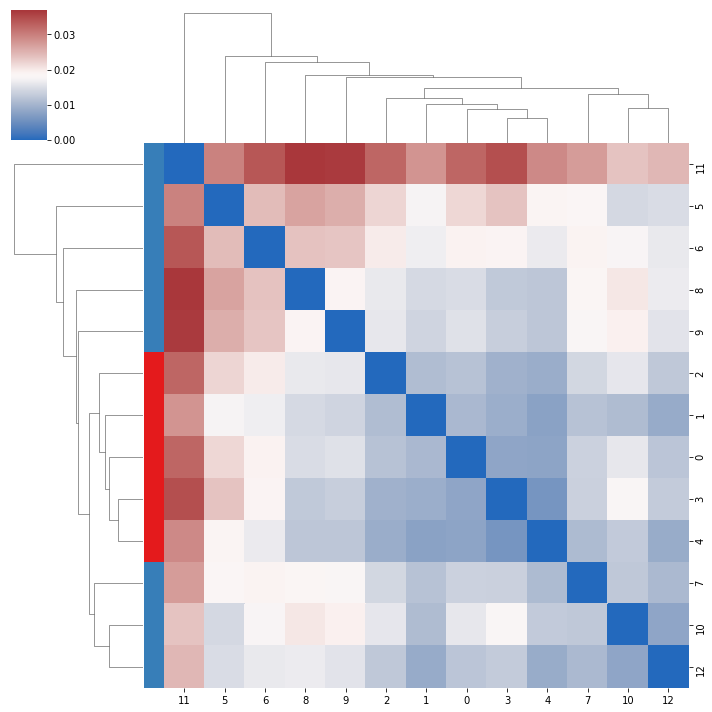

In [159]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean >=0].index.tolist()]
R1 = np.round(np.corrcoef(features), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
sns.clustermap(df_dist, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-188-33ff0a366977>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


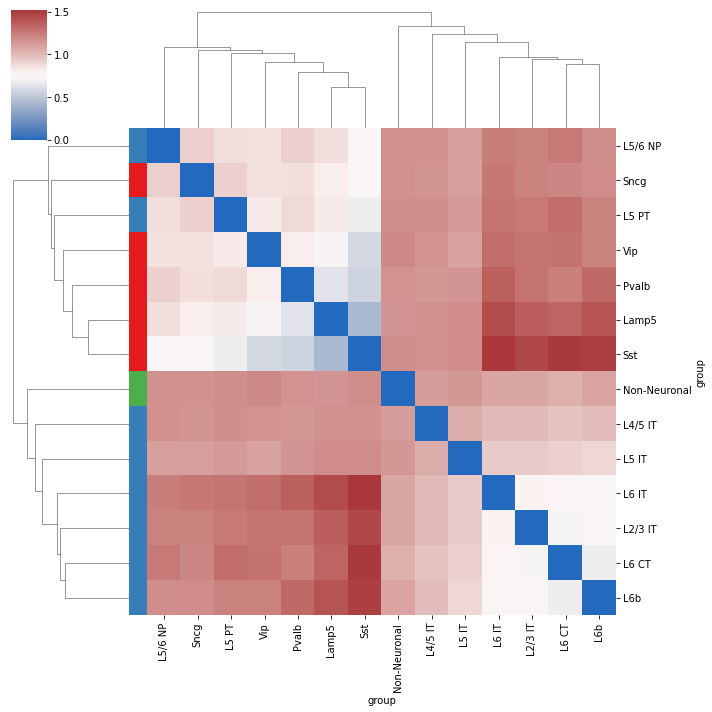

In [188]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [185]:
df_dist.shape

(13, 13)

In [183]:
features.index.get_level_values('group')

Index(['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip', 'L2/3 IT', 'L4/5 IT', 'L5 IT',
       'L5 PT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6b', 'Non-Neuronal'],
      dtype='object', name='group')

In [161]:
all_bins_mean.median()

-0.010484438389539719

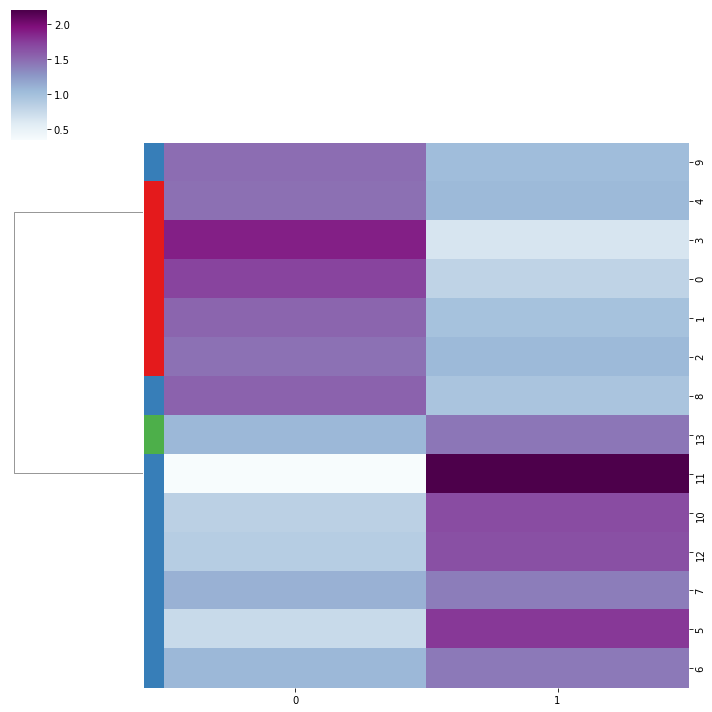

In [148]:
from sklearn.decomposition import NMF



features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
features_sc = abs(features_sc.min()) + features_sc

model = NMF(n_components=2, init='random', random_state=2)
W = model.fit_transform(features_sc)
H = model.components_
sns.clustermap(W, cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors,  metric="correlation")



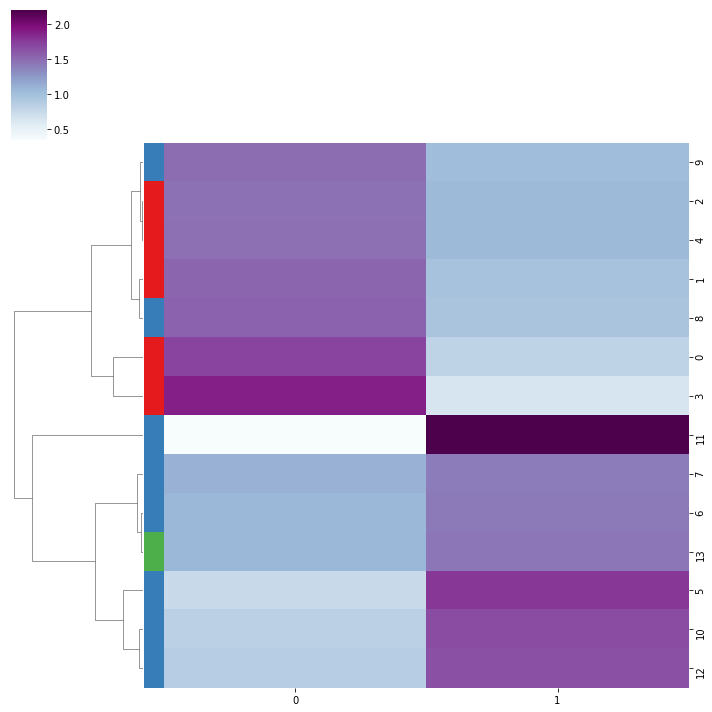

In [149]:
sns.clustermap(W, cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors)


<ipython-input-118-ada1e006cb4e>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


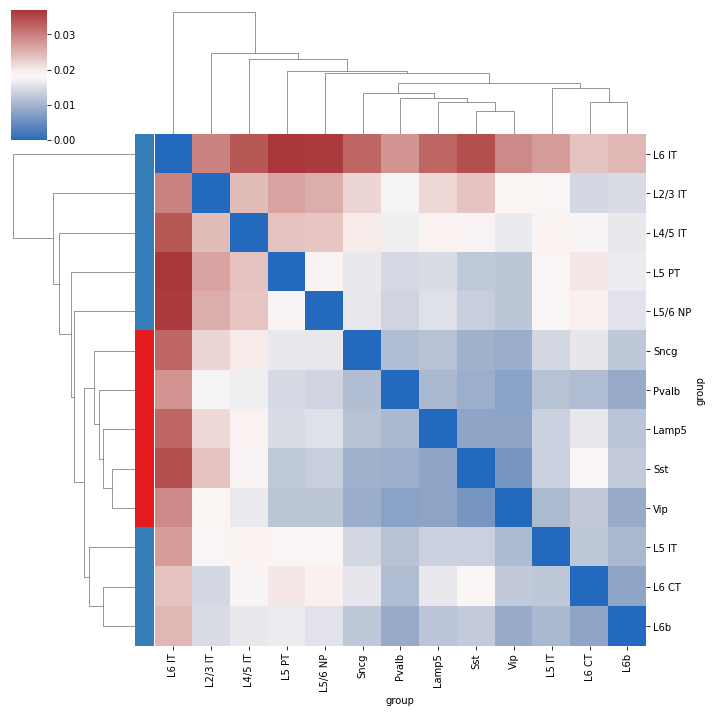

In [118]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean >=0].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


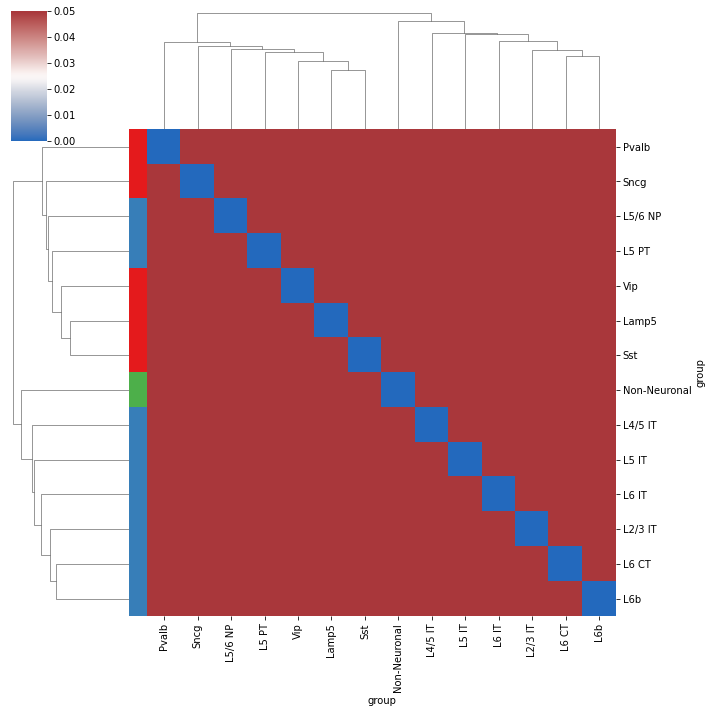

In [145]:
sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors, vmax=0.05)


In [119]:
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
R1 = R1 + abs(R1.min())
df_dist_df = pd.DataFrame(R1 ,  index=df_gene_tp_all_info_mean.index.get_level_values('group'), columns = df_gene_tp_all_info_mean.index.get_level_values('group'))


In [120]:
df_go = df_gene_tp_all_info_mean[[0]].reset_index()

df_go['val'] = 1

df_go_table = df_go.pivot_table(index='group', columns='classt', values='val', aggfunc='sum')
df_go_table.fillna(0, inplace=True)

(13, 13)
(13, 2)
0.5
0.011834319526627168


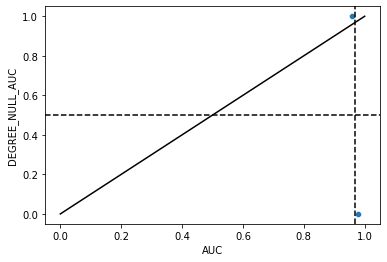

In [121]:

        df_2d_jac, go_chrom  = run_egad(df_go_table, df_dist_df )
        %matplotlib inline
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
        plt.plot([0, 1], [0, 1], c='black')
        plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
        plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [122]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
classt                                                             
GABAergic      0.958333         6.882918              1.0  0.001025
Glutamatergic  0.977778         6.131162              0.0  0.000209